created by Ignacio Oguiza - email: oguiza@gmail.com

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

<img src="./images/Rocket.svg"  width="150">

ROCKET (RandOm Convolutional KErnel Transform) is a new Time Series Classification (TSC) method that has just been released (Oct 29th, 2019), and has achieved **state-of-the-art performance on the UCR univariate time series classification datasets, surpassing HIVE-COTE (the previous state of the art since 2017) in accuracy, with exceptional speed compared to other traditional DL methods.** 

To achieve these 2 things at once is **VERY IMPRESSIVE**. ROCKET is certainly a new TSC method you should try.

Authors:
Dempster, A., Petitjean, F., & Webb, G. I. (2019). ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels. arXiv preprint arXiv:1910.13051.

[paper](https://arxiv.org/pdf/1910.13051)

There are 2 main limitations to the original ROCKET method though:
- The release code doesn't handle multivariate data
- It doesn't run on a GPU, so it's slow when used with a large datasets

In this notebook you will learn: 
- how you can use the original ROCKET method
- you will also learn about a new ROCKET version I have developed in Pytorch, that handles both univariate and multivariate data, and uses GPU
- you will see how you can integrate the ROCKET features with fastai or other classifiers

## Import libraries 📚

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai_timeseries import *
print('pytorch:', torch.__version__)
print('fastai :', fastai.__version__)

pytorch: 1.3.0
fastai : 1.0.59


## How to use the original ROCKET method? 🚀

ROCKET is applied in 2 phases:

1. Generate features from each time series: ROCKET calculates 20k features from each time series, independently of the sequence length. 
2. Apply a classifier to those calculated features. Those features are then used by the classifier of your choice. In the original code they use 2 simple linear classifiers: RidgeClassifierCV and Logistic Regression, but you can use any classifier.

### 1️⃣ Generate features

Let's first generate the features. We'll import data from a UCR Time Series dataset.

The original method requires the time series to be in a 2d array of dtype np.float64.

In [6]:
X_train, y_train, X_valid, y_valid = get_UCR_data('OliveOil')
seq_len = X_train.shape[-1]
X_train = X_train[:, 0].astype(np.float64)
X_valid = X_valid[:, 0].astype(np.float64)
X_train.shape, X_valid.shape

((30, 570), (30, 570))

Now we normalize the data to mean 0 and std 1 **'per sample'** (recommended by the authors), that is they set each sample to mean 0 and std 1).

In [7]:
X_train = (X_train - X_train.mean(axis = 1, keepdims = True)) / (X_train.std(axis = 1, keepdims = True) + 1e-8)
X_valid = (X_valid - X_valid.mean(axis = 1, keepdims = True)) / (X_valid.std(axis = 1, keepdims = True) + 1e-8)
X_train.mean(axis = 1, keepdims = True).shape

(30, 1)

To generate the features, we first need to create the 10k random kernels that will be used to process the data.

In [13]:
kernels = generate_kernels(seq_len, 10000)

Now we apply those ramdom kernels to the data

In [14]:
X_train_tfm = apply_kernels(X_train, kernels)
X_valid_tfm = apply_kernels(X_valid, kernels)

### 2️⃣ Apply a classifier

So now we have the features, and we are ready to apply a classifier. 

Let's use a simple, linear RidgeClassifierCV as they propose in the paper. We first instantiate it. 

Note:
alphas: Array of alpha values to try. Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization. Alpha corresponds to C^-1 in other linear models such as LogisticRegression or LinearSVC.

In [15]:
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)

In [16]:
 classifier.fit(X_train_tfm, y_train)

RidgeClassifierCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                  class_weight=None, cv=None, fit_intercept=True,
                  normalize=True, scoring=None, store_cv_values=False)

In [17]:
classifier.score(X_valid_tfm, y_valid)

0.9333333333333333

☣️ **This is pretty impressive! It matches or exceeds the state-of-the-art performance without any fine tuning in <2 seconds!!!**

In [20]:
kernels = generate_kernels(seq_len, 10000)
X_train_tfm = apply_kernels(X_train, kernels)
X_valid_tfm = apply_kernels(X_valid, kernels)
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)
classifier.fit(X_train_tfm, y_train)
classifier.score(X_valid_tfm, y_valid)

0.9

⚠️ Bear in mind that this process is not deterministic since there is randomness involved in the kernels. In thiis case, performance may vay between .9 to .933

## How to use ROCKET with large and/ or multivariate datasets on GPU? ❓

As stated before, the current ROCKET method doesn't support multivariate time series or GPU. This may be a drawback in some cases. 

To overcome both limitations I've created a multivariate ROCKET on GPU in Pytorch. 

In [4]:
import torch
import torch.nn as nn

class ROCKET(nn.Module):
    def __init__(self, c_in, seq_len, n_kernels=10000, kss=[7, 9, 11]):
        
        '''
        ROCKET is a GPU Pytorch implementation of the ROCKET methods generate_kernels 
        and apply_kernels that can be used  with univariate and multivariate time series.
        Input: is a 3d torch tensor of type torch.float32. When used with univariate TS, 
        make sure you transform the 2d to 3d by adding unsqueeze(1).
        c_in: number of channels or features. For univariate c_in is 1.
        seq_len: sequence length
        '''
        super().__init__()
        kss = [ks for ks in kss if ks < seq_len]
        convs = nn.ModuleList()
        for i in range(n_kernels):
            ks = np.random.choice(kss)
            dilation = 2**np.random.uniform(0, np.log2((seq_len - 1) // (ks - 1)))
            padding = int((ks - 1) * dilation // 2) if np.random.randint(2) == 1 else 0
            weight = torch.randn(1, c_in, ks)
            weight -= weight.mean()
            bias = 2 * (torch.rand(1) - .5)
            layer = nn.Conv1d(c_in, 1, ks, padding=2 * padding, dilation=int(dilation), bias=True)
            layer.weight = torch.nn.Parameter(weight, requires_grad=False)
            layer.bias = torch.nn.Parameter(bias, requires_grad=False)
            convs.append(layer)
        self.convs = convs
        self.n_kernels = n_kernels
        self.kss = kss

    def forward(self, x):
        for i in range(self.n_kernels):
            out = self.convs[i](x)
            _max = out.max(dim=-1).values
            _ppv = torch.gt(out, 0).sum(dim=-1).float() / out.shape[-1]
            cat = torch.cat((_max, _ppv), dim=-1)
            output = cat if i == 0 else torch.cat((output, cat), dim=-1)
        return output

The way to use ROCKET in Pytorch is the following:

### 1️⃣ Generate features

First you prepare the input data and normalize it per sample. The input to ROCKET Pytorch is a 3d tensor (preferrable on gpu)

In [159]:
X_train, y_train, X_valid, y_valid = get_UCR_data('HandMovementDirection')
_, features, seq_len = X_train.shape
X_train = (X_train - X_train.mean(axis=(1, 2), keepdims=True)) / (
    X_train.std(axis=(1, 2), keepdims=True) + 1e-8)
X_valid = (X_valid - X_valid.mean(axis=(1, 2), keepdims=True)) / (
    X_valid.std(axis=(1, 2), keepdims=True) + 1e-8)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

torch.Size([160, 10, 400]) torch.Size([74, 10, 400]) (160,) (74,)


Then you instantiate the Pytorch model.

In [160]:
n_kernels=10_000
kss=[7, 9, 11]
model = ROCKET(features, seq_len, n_kernels=n_kernels, kss=kss).to(device)

And we now transform the original data, creating 20k features per sample

In [161]:
X_train_tfm = model(X_train)
X_valid_tfm = model(X_valid)

### 2️⃣ Apply a classifier

#### RidgeClassifierCV

And now you apply a classifier of your choice. 
With RidgeClassifierCV in particular, there's no need to normalize the calculated features before passing them to the classifier, as it does it internally (if normalize is set to True as recommended by the authors).

In [162]:
from sklearn.linear_model import RidgeClassifierCV
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train_tfm, y_train)
print('alpha: {:.2E}  train: {:.5f}  valid: {:.5f}'.format(ridge.alpha_, 
                                                           ridge.score(X_train_tfm, y_train), 
                                                           ridge.score(X_valid_tfm, y_valid)))

alpha: 1.00E+01  train: 1.00000  valid: 0.48649


#### Logistic Regression

In the case of other classifiers (like Logistic Regression), the authors recommend a per-feature normalization.

In [164]:
eps = 1e-6
Cs = np.logspace(-5, 5, 11)
from sklearn.linear_model import LogisticRegression
best_loss = np.inf
for i, C in enumerate(Cs):
    f_mean = X_train_tfm.mean(axis=0, keepdims=True)
    f_std = X_train_tfm.std(axis=0, keepdims=True) + eps  # epsilon to avoid dividing by 0
    X_train_tfm2 = (X_train_tfm - f_mean) / f_std
    X_valid_tfm2 = (X_valid_tfm - f_mean) / f_std
    classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    classifier.fit(X_train_tfm2, y_train)
    probas = classifier.predict_proba(X_train_tfm2)
    loss = nn.CrossEntropyLoss()(torch.tensor(probas), torch.tensor(y_train)).item()
    train_score = classifier.score(X_train_tfm2, y_train)
    val_score = classifier.score(X_valid_tfm2, y_valid)
    if loss < best_loss:
        best_eps = eps
        best_C = C
        best_loss = loss
        best_train_score = train_score
        best_val_score = val_score
    print('{:2} eps: {:.2E}  C: {:.2E}  loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        i, eps, C, loss, train_score, val_score))
print('\nBest result:')
print('eps: {:.2E}  C: {:.2E}  train_loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        best_eps, best_C, best_loss, best_train_score, best_val_score))

 0 eps: 1.00E-06  C: 1.00E-05  loss: 1.36964  train_acc: 0.80625  valid_acc: 0.43243
 1 eps: 1.00E-06  C: 1.00E-04  loss: 1.28455  train_acc: 1.00000  valid_acc: 0.45946
 2 eps: 1.00E-06  C: 1.00E-03  loss: 1.09687  train_acc: 1.00000  valid_acc: 0.47297
 3 eps: 1.00E-06  C: 1.00E-02  loss: 0.87247  train_acc: 1.00000  valid_acc: 0.45946
 4 eps: 1.00E-06  C: 1.00E-01  loss: 0.76865  train_acc: 1.00000  valid_acc: 0.45946
 5 eps: 1.00E-06  C: 1.00E+00  loss: 0.74737  train_acc: 1.00000  valid_acc: 0.45946
 6 eps: 1.00E-06  C: 1.00E+01  loss: 0.74417  train_acc: 1.00000  valid_acc: 0.44595
 7 eps: 1.00E-06  C: 1.00E+02  loss: 0.74374  train_acc: 1.00000  valid_acc: 0.44595
 8 eps: 1.00E-06  C: 1.00E+03  loss: 0.74370  train_acc: 1.00000  valid_acc: 0.43243
 9 eps: 1.00E-06  C: 1.00E+04  loss: 0.74370  train_acc: 1.00000  valid_acc: 0.50000
10 eps: 1.00E-06  C: 1.00E+05  loss: 0.74369  train_acc: 1.00000  valid_acc: 0.51351

Best result:
eps: 1.00E-06  C: 1.00E+05  train_loss: 0.74369  tr

This result is amazing!! The previous state of the art (Inceptiontime) was .37837

☣️ Note: Epsilon has a large impact on the result. You can actually test several values to find the one that best fits your problem, but bear in mind you can only select C and epsilon based on train data!!! 

##### RandomSearch

One way to do this would be to performa a random search using several epsilon and C values

In [166]:
n_tests = 10
epss = np.logspace(-8, 0, 9)
Cs = np.logspace(-5, 5, 11)

from sklearn.linear_model import LogisticRegression
best_loss = np.inf
for i in range(n_tests):
    eps = np.random.choice(epss)
    C = np.random.choice(Cs)
    f_mean = X_train_tfm.mean(axis=0, keepdims=True)
    f_std = X_train_tfm.std(axis=0, keepdims=True) + eps  # epsilon
    X_train_tfm2 = (X_train_tfm - f_mean) / f_std
    X_valid_tfm2 = (X_valid_tfm - f_mean) / f_std
    classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    classifier.fit(X_train_tfm2, y_train)
    probas = classifier.predict_proba(X_train_tfm2)
    loss = nn.CrossEntropyLoss()(torch.tensor(probas), torch.tensor(y_train)).item()
    train_score = classifier.score(X_train_tfm2, y_train)
    val_score = classifier.score(X_valid_tfm2, y_valid)
    if loss < best_loss:
        best_eps = eps
        best_C = C
        best_loss = loss
        best_train_score = train_score
        best_val_score = val_score
    print('{:2}  eps: {:.2E}  C: {:.2E}  loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        i, eps, C, loss, train_score, val_score))
print('\nBest result:')
print('eps: {:.2E}  C: {:.2E}  train_loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        best_eps, best_C, best_loss, best_train_score, best_val_score))

 0  eps: 1.00E+00  C: 1.00E-03  loss: 1.18504  train_acc: 1.00000  valid_acc: 0.36486
 1  eps: 1.00E-06  C: 1.00E-01  loss: 0.76865  train_acc: 1.00000  valid_acc: 0.45946
 2  eps: 1.00E+00  C: 1.00E+05  loss: 0.74368  train_acc: 1.00000  valid_acc: 0.47297
 3  eps: 1.00E-07  C: 1.00E+01  loss: 0.74417  train_acc: 1.00000  valid_acc: 0.45946
 4  eps: 1.00E-05  C: 1.00E+02  loss: 0.74374  train_acc: 1.00000  valid_acc: 0.45946
 5  eps: 1.00E-06  C: 1.00E+01  loss: 0.74417  train_acc: 1.00000  valid_acc: 0.44595
 6  eps: 1.00E-06  C: 1.00E-05  loss: 1.36964  train_acc: 0.80625  valid_acc: 0.43243
 7  eps: 1.00E-03  C: 1.00E+04  loss: 0.74370  train_acc: 1.00000  valid_acc: 0.43243
 8  eps: 1.00E-02  C: 1.00E-01  loss: 0.77127  train_acc: 1.00000  valid_acc: 0.43243
 9  eps: 1.00E+00  C: 1.00E+01  loss: 0.74478  train_acc: 1.00000  valid_acc: 0.37838

Best result:
eps: 1.00E+00  C: 1.00E+05  train_loss: 0.74368  train_acc: 1.00000  valid_acc: 0.47297


### Results: accuracy and time

I've checked the performance for all 85 univariate datasets in the UCR archive, and performance is the same as the published one. 

**Average performance accross all datasets is 85.100% (original) vs	85.085% (with the Pytorch version).**

I've also run some tests to and compared performance (time) of ROCKET original code vs Pytorch. These are the results:

<img src="./images/Time_ROCKET_comp.png" width=800>

So, as you can see, in small datasets, the original method may be a bit faster than the GPU method, but for larger datasets, there's a great benefit in using the GPU version.

In addition to this, I have also run the code on the TSC UCR multivariate datasets (all the ones that don't contain nan values), and the results are also very good, beating the previous state-of-the-art in this category as well by a large margin. For example, ROCKET reduces InceptionTime errors by 26% on average.

In [7]:
iterations = 5
datasets = sorted(get_UCR_multivariate_list())
n_kernels=10_000
kss=[7, 9, 11]

ds_ = []
ds_nl_ = []
ds_di_ = []
ds_type_ = []
iters_ = []
means_ = []
stds_ = []
times_ = []
alphas_ = []

datasets = listify(datasets)
for dsid in datasets:
    try: 
        print(f'\nProcessing {dsid} dataset...\n')
        if dsid in get_UCR_univariate_list(): scale_type=None
        else: scale_type='standardize'
        data = create_UCR_databunch(dsid, bs=2048, scale_type=scale_type, verbose=True)
        X_train = data.train_ds.x.items.astype(np.float32)
        X_valid = data.valid_ds.x.items.astype(np.float32)
        y_train = data.train_ds.y.items.astype(np.int64)
        y_valid = data.valid_ds.y.items.astype(np.int64)
    except: 
        ds_nl_.append(dsid)
        print(f'\n...{dsid} cannot be loaded\n')
        continue
    if np.isinf(X_train).sum() + np.isnan(X_train).sum() > 0: 
        ds_di_.append(dsid)
        print(f'...{dsid} contains inf or nan\n')
        continue
        
    if data.features == 1: ds_type_.append('univariate')
    else: ds_type_.append('multivariate')
    
    score_ = []
    elapsed_times_ = []
    for i in range(iterations):
        start_time = time.time()
        model = ROCKET(data.features, data.seq_len, n_kernels=n_kernels,kss=kss).to(device)
        for j, (xb,yb) in enumerate(data.train_dl.new(shuffle=False, drop_last=False)):
            with torch.no_grad(): out = model(xb)
            X_train_tfm = out if j == 0 else torch.cat((X_train_tfm, out))
        for j, (xb,yb) in enumerate(data.valid_dl.new(shuffle=False, drop_last=False)):
            with torch.no_grad(): out = model(xb)
            X_valid_tfm = out if j == 0 else torch.cat((X_valid_tfm, out))
        classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)
        classifier.fit(X_train_tfm, y_train)
        score = classifier.score(X_valid_tfm, y_valid)
        score_.append(score)
        elapsed_time = time.time() - start_time
        elapsed_times_.append(elapsed_time)
        alphas_.append(classifier.alpha_)
        print('   {:2} - score: {:.5f}  alpha: {:.2E}  time(s): {:4.0f}'.\
              format(i + 1, score, classifier.alpha_, elapsed_time))
    ds_.append(dsid)
    iters_.append(iterations)
    means_.append('{:.6f}'.format(np.mean(score_)))
    stds_.append('{:.6f}'.format(np.std(score_)))
    times_.append('{:.0f}'.format(np.mean(elapsed_times_)))
    if len(datasets) >1: clear_output()
    df = pd.DataFrame(np.stack((ds_, ds_type_, iters_,  means_, stds_, times_)).T, 
             columns=['dataset', 'type', 'iterations',  'mean_accuracy', 'std_accuracy',  'time(s)'])
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    display(df)
    pd.set_option('display.max_columns', 20)
    pd.set_option('display.max_rows', 60)
    if ds_nl_ != []: print('\n(*) datasets not loaded      :', ds_nl_)
    if ds_di_ != []:print('(*) datasets with data issues:', ds_di_)

,dataset,type,iterations,mean_accuracy,std_accuracy,time(s)
0,ArticularyWordRecognition,multivariate,5,0.992667,0.001333,14
1,AtrialFibrillation,multivariate,5,0.306667,0.053333,13
2,BasicMotions,multivariate,5,1.000000,0.000000,13
3,Cricket,multivariate,5,1.000000,0.000000,13
4,ERing,multivariate,5,0.954074,0.002963,13
5,EigenWorms,multivariate,5,0.819847,0.013310,78
6,Epilepsy,multivariate,5,0.963768,0.000000,13
7,EthanolConcentration,multivariate,5,0.292015,0.001521,15
8,FingerMovements,multivariate,5,0.534000,0.008000,14
9,HandMovementDirection,multivariate,5,0.475676,0.026204,13



(*) datasets not loaded      : ['DuckDuckGeese', 'FaceDetection', 'InsectWingbeat']
(*) datasets with data issues: ['CharacterTrajectories', 'JapaneseVowels', 'SpokenArabicDigits']


This is the comparison with InceptionTime:

<img src="./images/ROCKET_InceptionTime_multi.png"  width="400">

## And how to use it with other classifiers? 

Once you build the 20k features per sample, you can use them to train any classifier of your choice.

If you want to use fastai, for example, with a logistic regression, you could should then build a databunch and a logistic regression model.

### Integration with fastai

These are the steps to use ROCKET with a classifier in fastai:

1. Normalize the data 'per sample' (if not previously normalized)
2. Calculate features
3. Normalize calculated features 'per feature' (you'll get 20k means and stds)
4. Create the databunch passing the normalized calculated features as 3d tensor/arrays to a TSList.

In [250]:
dsid = 'OliveOil'
bs = 30
eps = 1e-6

# extract data
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)

# normalize data 'per sample'
X_train = (X_train - X_train.mean(axis=(1, 2), keepdims=True)) / (
    X_train.std(axis=(1, 2), keepdims=True) + eps)
X_valid = (X_valid - X_valid.mean(axis=(1, 2), keepdims=True)) / (
    X_valid.std(axis=(1, 2), keepdims=True) + eps)

# calculate 20k features
_, features, seq_len = X_train.shape
model = ROCKET(features, seq_len, n_kernels=10000, kss=[7, 9, 11]).to(device)
X_train_tfm = model(torch.tensor(X_train, device=device)).unsqueeze(1)
X_valid_tfm = model(torch.tensor(X_valid, device=device)).unsqueeze(1)

# normalize 'per feature'
f_mean = X_train_tfm.mean(dim=0, keepdims=True)
f_std = X_train_tfm.std(dim=0, keepdims=True) + eps
X_train_tfm_norm = (X_train_tfm - f_mean) / f_std
X_valid_tfm_norm = (X_valid_tfm - f_mean) / f_std

In [251]:
# create databunch
data = (ItemLists('.', TSList(X_train_tfm_norm), TSList(X_valid_tfm_norm))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=min(bs, len(X_train)), val_bs=min(bs * 2, len(X_valid)))
       )
data

TSDataBunch;

Train: LabelList (30 items)
x: TSList
TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (30 items)
x: TSList
TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000)
y: CategoryList
0,0,0,0,0
Path: .;

Test: None

Let's take a look at the output of ROCKET.

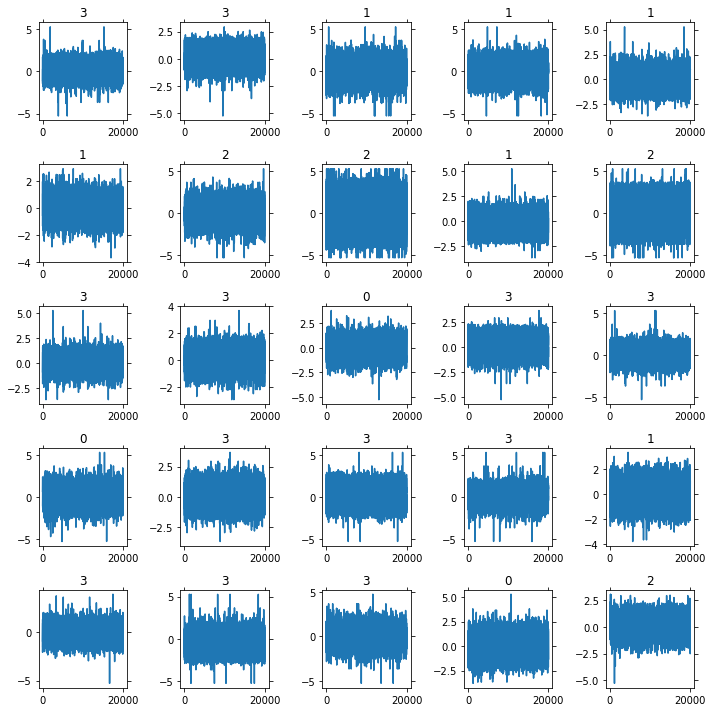

In [252]:
data.show_batch()

In this case we'll use a very simple: a Logistic Regression with 20k input features and 2 classes in this case.

In [303]:
def init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.constant_(layer.weight.data, 0.)
        nn.init.constant_(layer.bias.data, 0.)

In [304]:
model = nn.Sequential(nn.Linear(20_000, data.c))
model.apply(init)
learn = Learner(data, model, metrics=accuracy)
learn.save('stage-0')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


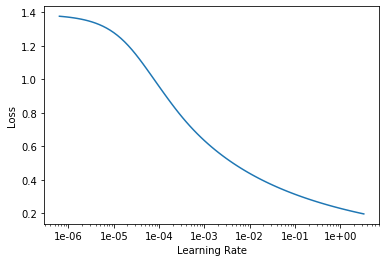

In [306]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.386295,0.792708,0.733333,00:00
1,1.005563,0.859757,0.833333,00:00
2,0.712022,0.868866,0.933333,00:00
3,0.529538,1.075771,0.933333,00:00
4,0.419462,1.160817,0.933333,00:00
5,0.346049,1.186099,0.933333,00:00
6,0.293623,1.196733,0.933333,00:00
7,0.254319,1.209124,0.933333,00:00
8,0.223763,1.221544,0.933333,00:00
9,0.199329,1.226621,0.933333,00:00


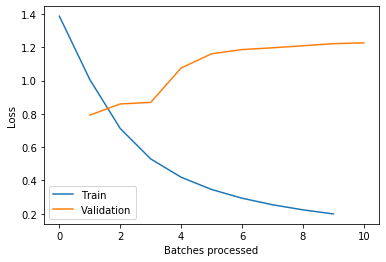

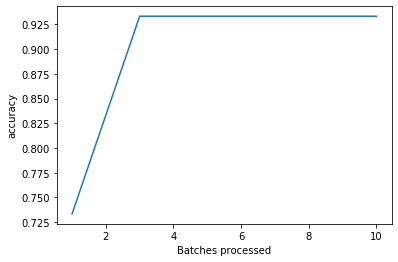

In [302]:
learn.load('stage-0')
learn.fit_one_cycle(10, max_lr=3e-3, wd=1e2)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

This is an excellent result we have achieved with a very simple classifier (Logistic Regression)

### Boosted trees: XGBoost

In [5]:
dsid = 'OliveOil'
eps = 1e-6

# extract data
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)

# normalize data 'per sample'
X_train = (X_train - X_train.mean(axis=(1, 2), keepdims=True)) / (
    X_train.std(axis=(1, 2), keepdims=True) + eps)
X_valid = (X_valid - X_valid.mean(axis=(1, 2), keepdims=True)) / (
    X_valid.std(axis=(1, 2), keepdims=True) + eps)

# calculate 20k features
_, features, seq_len = X_train.shape
model = ROCKET(features, seq_len, n_kernels=10000, kss=[7, 9, 11]).to(device)
X_train_tfm = model(torch.tensor(X_train, device=device))
X_valid_tfm = model(torch.tensor(X_valid, device=device))

# normalize 'per feature'
f_mean = X_train_tfm.mean(dim=0, keepdims=True)
f_std = X_train_tfm.std(dim=0, keepdims=True) + eps
X_train_tfm_norm = (X_train_tfm - f_mean) / f_std
X_valid_tfm_norm = (X_valid_tfm - f_mean) / f_std

In [18]:
import xgboost as xgb
classifier = xgb.XGBClassifier(max_depth=3,
                               learning_rate=0.1,
                               n_estimators=100,
                               verbosity=1,
                               objective='binary:logistic',
                               booster='gbtree',
                               tree_method='auto',
                               n_jobs=1,
                               gpu_id=-1,
                               gamma=0,
                               min_child_weight=1,
                               max_delta_step=0,
                               subsample=.5,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               colsample_bynode=1,
                               reg_alpha=0,
                               reg_lambda=1,
                               scale_pos_weight=1,
                               base_score=0.5,
                               random_state=0,
                               missing=None)

classifier.fit(X_train_tfm, y_train)
preds = classifier.predict(X_valid_tfm)
(preds == y_valid).mean()

0.9666666666666667

## Conclusions

ROCKET is a great method for TSC that has established a new level of performance both in terms of accuracy and time. It does it by successfully applying an approach quite different from the traditional DL approaches. The method uses 10k random kernels to generate features that are then classified by linear classifiers (although you may use a classifier of your choice).
The original method has 2 limitations (lack of multivariate and lack of GPU support) that are overcome by the Pytorch implementation shared in this notebook.